# Face Segmentation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1">Summary</a></span></li><li><span><a href="#Section-1---Setup" data-toc-modified-id="Section-1---Setup-2">Section 1 - Setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1">Imports</a></span></li><li><span><a href="#Constants-and-Setup" data-toc-modified-id="Constants-and-Setup-2.2">Constants and Setup</a></span></li></ul></li><li><span><a href="#Section-2---Data-Cleaning-and-Exploration" data-toc-modified-id="Section-2---Data-Cleaning-and-Exploration-3">Section 2 - Data Cleaning and Exploration</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Fixing-class-labels" data-toc-modified-id="Fixing-class-labels-3.0.1">Fixing class labels</a></span></li><li><span><a href="#Ensuring-consistency-across-the-labels" data-toc-modified-id="Ensuring-consistency-across-the-labels-3.0.2">Ensuring consistency across the labels</a></span></li></ul></li><li><span><a href="#Loading-/-Pre-processing-the-entire-dataset" data-toc-modified-id="Loading-/-Pre-processing-the-entire-dataset-3.1">Loading / Pre-processing the entire dataset</a></span><ul class="toc-item"><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-3.1.1">Downsampling</a></span></li></ul></li></ul></li><li><span><a href="#Section-3---Modelling" data-toc-modified-id="Section-3---Modelling-4">Section 3 - Modelling</a></span><ul class="toc-item"><li><span><a href="#Model-1---RF-No-HOG" data-toc-modified-id="Model-1---RF-No-HOG-4.1">Model 1 - RF No HOG</a></span></li><li><span><a href="#Model-2---RF-with-HOG" data-toc-modified-id="Model-2---RF-with-HOG-4.2">Model 2 - RF with HOG</a></span></li><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-4.3">Model evaluation</a></span></li></ul></li></ul></div>

## Summary
This notebook demonstrates the processing of devloping a classifier for segmenting parts of a human face.

## Section 1 - Setup

### Imports
Importing required packages - some complexity as I wanted this notebook to run on both a local jupyter notebook and google colab.

In [54]:
# Standard imports
import sys
import importlib
import pandas as pd
import numpy as np
import re
import joblib
import pickle
import copy

# Imports for plotting
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Are we running on local or colab?
if 'edwardrees' in sys.exec_prefix:
    device_loc = 'local'
else:
    device_loc = 'colab'

# Print where running
print('Running on', device_loc)

# Mount drive if on colab
if device_loc == 'colab':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

# Add local drive to path if running on colab
if device_loc == 'local':
    dir_ = '..'
elif device_loc == 'colab':
    dir_ = 'drive/My Drive/GA/Capstone'
    sys.path.append(dir_)
sys.path.append(f'{dir_}/src')


# Images and loading
from skimage import io, util
import os
from matplotlib import cm
from matplotlib.colors import ListedColormap

# Progress bars, tqdm.notebook doesn't work on colab
if device_loc == 'colab':
    !pip install --force https://github.com/chengs/tqdm/archive/colab.zip
    from tqdm import tqdm_notebook as tqdm
elif device_loc == 'local':
    from tqdm.notebook import tqdm

# Import my functions
import image_processing as ip
import label_processing as lbp
import feature_processing as ftp
import utility_functions as util

# Models
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
import skimage.measure
from sklearn.pipeline import Pipeline

Running on local


### Constants and Setup

In [2]:
# Setup a better colour map for plotting segmented faces
newcmp=plt.cm.get_cmap('Set1', 8)

In [35]:
# Specfying image shape, used later when resizing the images to be a uniform size
IMG_SHAPE = (600, 600)

# Dataset locations, thee are two sections of the database
seg_v2_RGB_dir = dir_ + '/data/raw/FASSEG_v2/RGB'
seg_v2_labels_dir = dir_ + '/data/raw/FASSEG_v2/Labels'
seg_v3_RGB_dir = dir_ + '/data/raw/FASSEG_v3/RGB'
seg_v3_labels_dir = dir_ + '/data/raw/FASSEG_v3/Labels'

# Processed data location
processed_data_dir = dir_ + '/data/processed'

#real_dir = dir_+'/rawdata/real_and_fake_face/training_real'
#fake_dir = dir_+'/rawdata/real_and_fake_face/training_fake'

In [4]:
def reload_modules():
    '''
    Reload my custom modules in case something has changed
    '''
    importlib.reload(ip)
    importlib.reload(lbp)
    importlib.reload(ftp)
    importlib.reload(util)

## Section 2 - Data Cleaning and Exploration

Here the FASSEG dataset is investigated and cleaned up in preparation for modelling

In [5]:
# Load some of the iamges and inspect, this utilies the function I wrote load_images
# loads the images and corresponding labels 

# Images and labels are loaded together
img_sample, label_sample = ip.load_images(seg_v2_RGB_dir, seg_v2_labels_dir, max_imgs=5)

Loading Images: 100%|██████████| 5/5 [00:00<00:00, 60.18it/s]


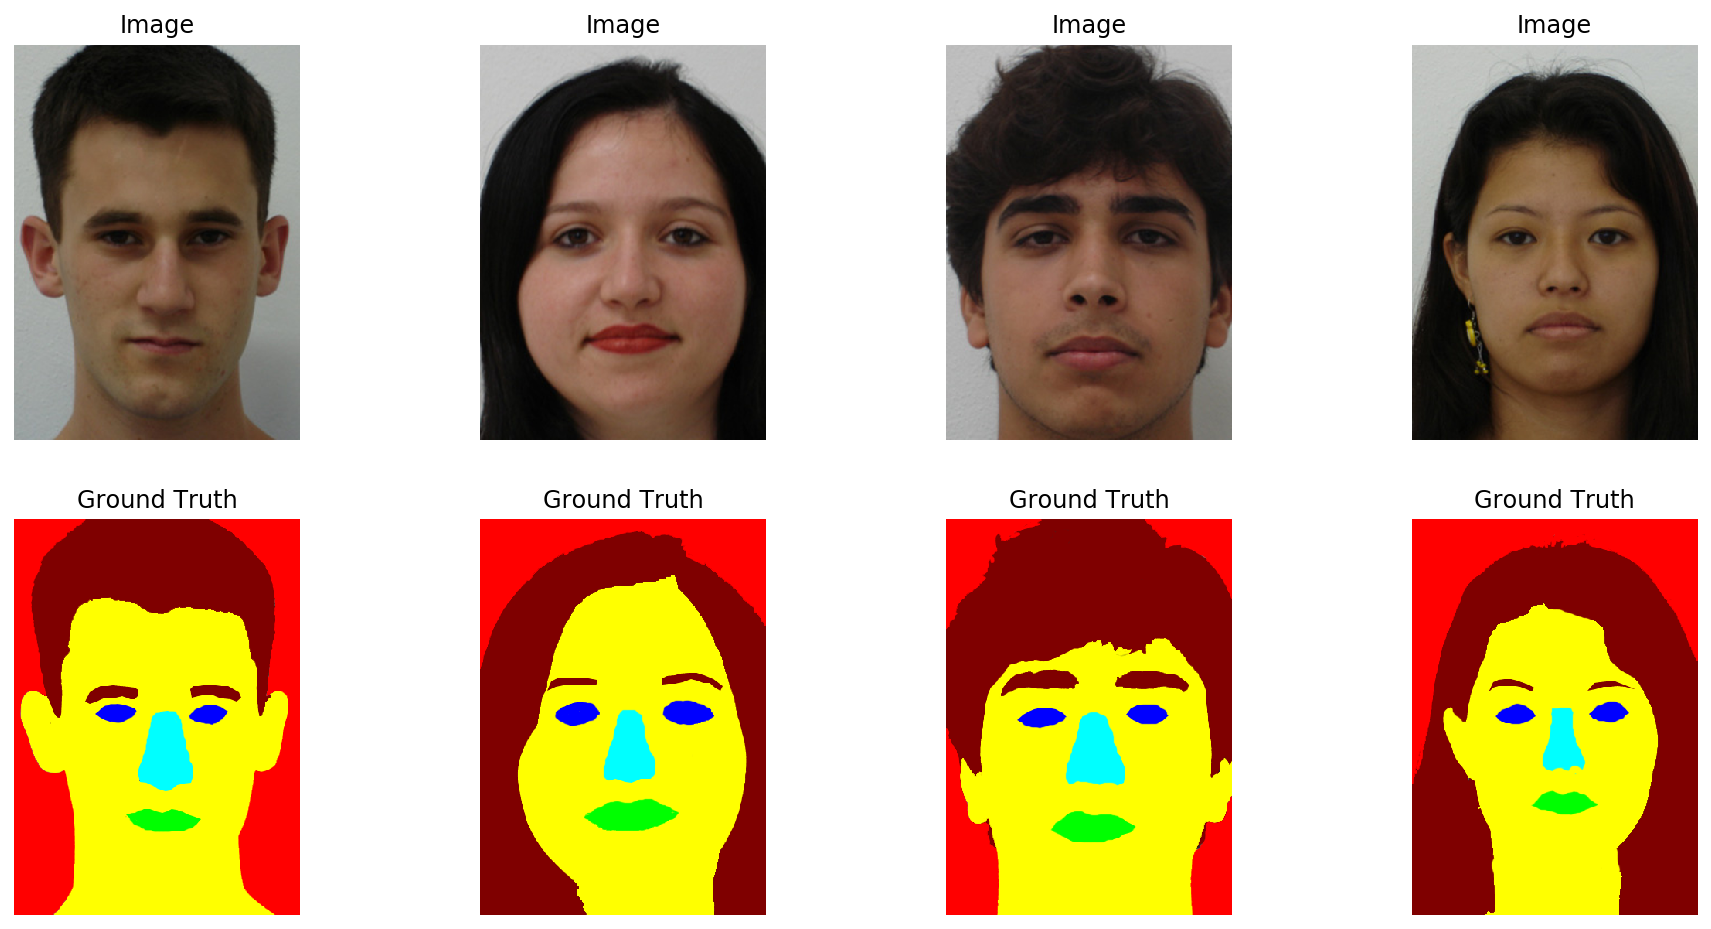

In [6]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))
for i in range(4):
    axi = ax[:,i]
    util.view_data(img_sample[i], gt=label_sample[i], ax=axi, axis=0)

The images are all the same height but having varying widths. The function `convert_images_to_array` below resizes the images (padding them if necessary) and reutrns a numpy array of the concatanated images.

In [7]:
img_sample_rs = ip.convert_images_to_array(img_sample, img_shape=(600,600))
label_sample_rs = ip.convert_images_to_array(label_sample, img_shape=(600,600))

Converting images to np array: 100%|██████████| 5/5 [00:00<00:00, 21.89it/s]


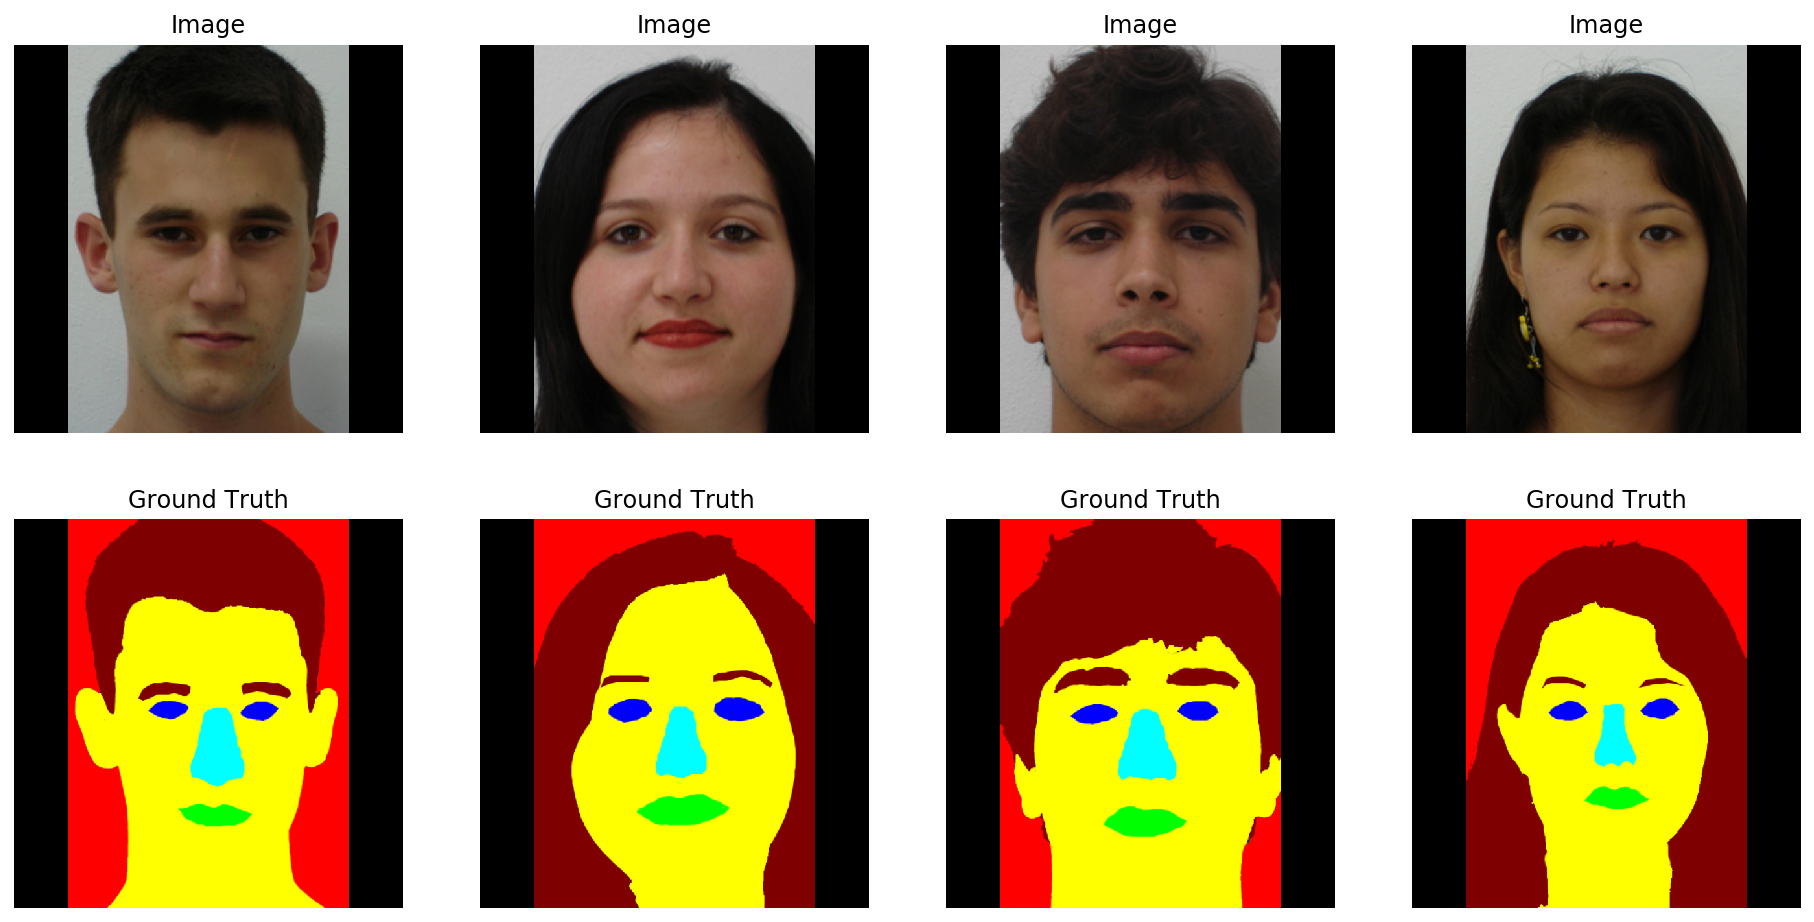

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))
for i in range(4):
    axi = ax[:,i]
    util.view_data(img_sample_rs[i], gt=label_sample_rs[i], ax=axi, axis=0)

#### Fixing class labels

Additionally looking at the labels it is clear that there are more unique colors then there are classes, this is because the images are in jpeg format and hence lost some of their precision during compression. These labels need to be fixed before they can be used to train the model.

In [9]:
print('Number of unique colors:', len(np.unique(label_sample[0])))

Number of unique colors: 256


The function `run_kmeans` below runs a k means clustering algorithm to reduce the colours in the labels into a specified number of clusters. This is done on a pixel by pixel basis taking into account only the color values. The function outputs a numpy array of the same shape of the input image with each pixel denoated by an integer in the range (0, n_clusters). 

In [10]:
clustered_label_1 = lbp.run_kmeans(label_sample_rs[0], n_clusters=7)
clustered_label_2 = lbp.run_kmeans(label_sample_rs[1], n_clusters=7)

Number of unique colors: 7
Class labels: [1 2 3 4 5 6 7]


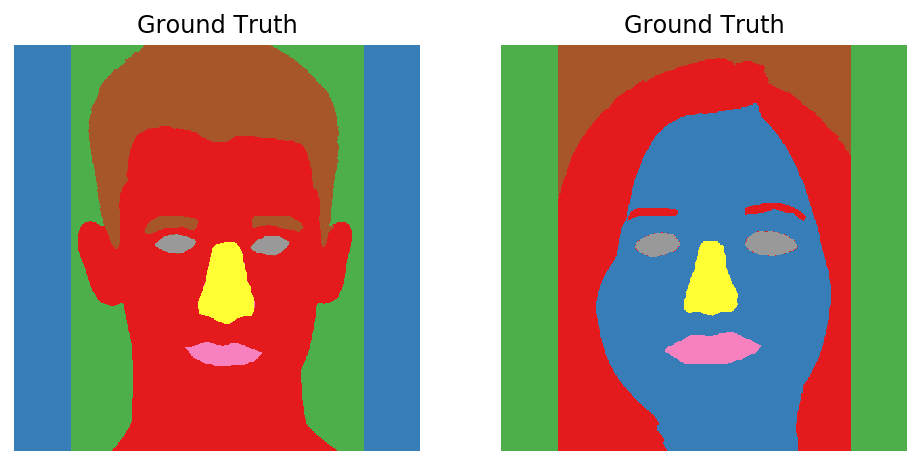

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
util.view_data(gt=clustered_label_1, ax=ax[0])
util.view_data(gt=clustered_label_2, ax=ax[1])
print('Number of unique colors:', len(np.unique(clustered_label_1)))
print('Class labels:', np.unique(clustered_label_1))

Whilst the number of unique colours in the labes is reduced to the number of classes, the k means algorithm outputs class labels in an arbitrary order. Hence it was necessary to create a second process that maps the outputs of the kmeans algorithm such that all labels of the labels are consistent. This is discussed in the next section

#### Ensuring consistency across the labels

In order to map the labels above to be uniform across all images it was necessary to compare the clean label above with the raw segmentation label.

By concatingating the rgb values of the raw segmentation labels to a string as r-g-b and then performing a value count it is straightforward to see what color the labels are meant to be and then by masking the label, discover what color correpsonds to which class.

In [12]:
# Working out what the top labels are, the class MakeFlat makes it straightforward to flatten/unflatten
#images whilst maintaing the different channel
make_flat = ip.MakeFlat(label_sample_rs[0].shape)
flat_image = make_flat.transform(label_sample_rs[0])

# Concatanting the RGB values into a string for each pixel in the image
pixel_values = [
    f'{pixel[0]}-{pixel[1]}-{pixel[2]}' for pixel in flat_image[:, :3]
]

# Display the top 7 colors in the images - these correspond to the segmented colors
pixel_values = pd.Series(pixel_values)
pixel_values.value_counts()[:7]

255-255-0    120017
0-0-0        100200
255-0-0       65961
127-0-0       53190
0-255-255      6504
0-255-0        2387
0-0-255        1873
dtype: int64

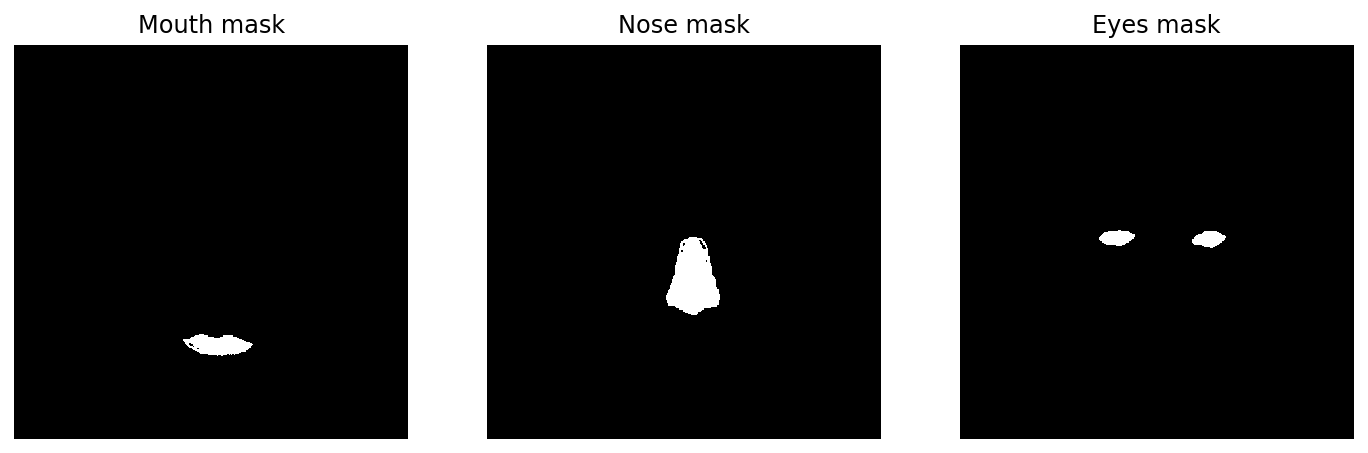

In [13]:
# The following dictionary indiciates in r-g-b what the colors are in the original labels, the 
# integer also shows the class label that should be assigned in the clean segmented labels.
raw_label_mapping = {
    'mouth': ['0-255-0', 1],
    'skin': ['255-255-0', 6],
    'hair': ['127-0-0', 5],
    'padding': ['0-0-0', 0],
    'nose': ['0-255-255', 2],
    'eyes': ['0-0-255', 3],
    'background': ['255-0-0', 7]
}

# Function to implment the above
nose = lbp.mask_image(label_sample_rs[0],
                      'nose',
                      raw_label_mapping,
                      method='color_label',
                      return_type='white')

mouth = lbp.mask_image(label_sample_rs[0],
                       'mouth',
                       raw_label_mapping,
                       method='color_label',
                       return_type='white')

eyes = lbp.mask_image(label_sample_rs[0],
                       'eyes',
                       raw_label_mapping,
                       method='color_label',
                       return_type='white')

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
util.view_data(gt=mouth, ax=ax[0])
util.view_data(gt=nose, ax=ax[1])
util.view_data(gt=eyes, ax=ax[2])
ax[0].set_title('Mouth mask')
ax[1].set_title('Nose mask')
ax[2].set_title('Eyes mask')
plt.show()

In [14]:
# Desired labels
desired_labels = [
    'mouth',
    'skin',
    'hair',
    'nose',
    'left_eye',
    'right_eye',
]

The function below implments a number steps, to view the source code click [here](../src/labed_processing)

1. Run the Kmeans algorithm to reduce the raw semgented labels into 7 distinct integer classes
2. For each of mouth, nose, eyes etc.. mask the raw segmented labels using the function above 
3. Comparing the output of 1. and 2. map the output of the kmeans algorithm to the class label specified in `label_dict` e.g. mouth=1, nose=2 etc
4. Repeat for each image

In [15]:
reload_modules()

In [16]:
seg1, mapping = lbp.segment_labeled_image(
    label_sample_rs[0],
    n_clusters=7,
    label_dict=raw_label_mapping,
    desired_labels=desired_labels,
    return_mapping=True)

In [17]:
seg2 = lbp.segment_labeled_image(
    label_sample_rs[1],
    n_clusters=7,
    label_dict=raw_label_mapping,
    desired_labels=desired_labels)

Number of unique colors: 7
Class labels: [0 1 2 3 4 5 6]


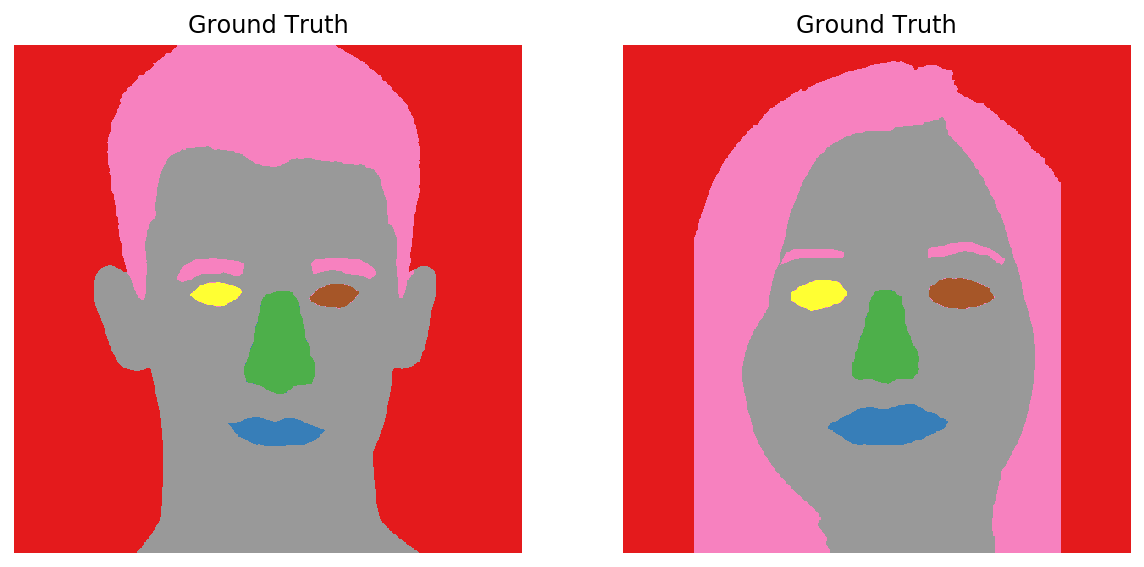

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
util.view_data(gt=seg1, ax=ax[0])
util.view_data(gt=seg2, ax=ax[1])
print('Number of unique colors:', len(np.unique(seg1)))
print('Class labels:', np.unique(seg2))

The two images above now show that the class labels in the segmented image are uniform across both images. In the next section these steps are applied to every raw segmented label to prepare the data for modelling.

### Loading / Pre-processing the entire dataset


The code below loads all of the images in the database, resizes them, and then cleans up the semgentation labels as per the steps discussed above. The results are then saved as a compressed numpy array to avoid re-running the steps.

In [38]:
# Labels have some noise so segment them to obtain clean categories,
force_recalculate = False
imgs_path = f'{processed_data_dir}/imgs_array.npz'
labels_path = f'{processed_data_dir}/labels_array.npz'
desired_labels = (['skin', 'nose', 'mouth', 'eyes', 'hair'])

if not os.path.exists(imgs_path) or force_recalculate:

    # Check that the segmentation folder exists
    if not os.path.exists(f'{processed_data_dir}segmentation'):
        os.makedirs(f'{processed_data_dir}segmentation')

    # Load images from FASSEG V2 database and save the result as two lists
    seg_v2_RGB, seg_v2_labels = ip.load_images(seg_v2_RGB_dir,
                                               seg_v2_labels_dir)

    # Load images from FASSEG V3 database and save the result as two lists
    seg_v3_RGB, seg_v3_labels = ip.load_images(seg_v3_RGB_dir,
                                               seg_v3_labels_dir)

    # Combine V2 and V3 into a combined list
    seg_v2_v3_RGB = seg_v2_RGB + seg_v3_RGB
    seg_v2_v3_labels = seg_v2_labels + seg_v3_labels

    # Convert list of images to numpy array
    X = ip.convert_images_to_array(seg_v2_v3_RGB, IMG_SHAPE, method='zero_pad')
    Y = ip.convert_images_to_array(seg_v2_v3_labels,
                                   IMG_SHAPE,
                                   method='zero_pad')

    # Segment the Y labels as discussed above
    Y = lbp.segment_labeled_images(Y,
                                   n_clusters=7,
                                   label_dict=raw_label_mapping,
                                   desired_labels=desired_labels)

    # Save the results as this takes a while to run
    np.savez_compressed(imgs_path, imgs=X)
    np.savez_compressed(labels_path, labels=Y)
    print('Saved images and semgentation labels')

else:
    # Else Load the segmented labels if
    loaded_imgs = np.load(imgs_path)
    loaded_labels = np.load(labels_path)
    X = loaded_imgs['imgs']
    Y = loaded_labels['labels']
    print('Loaded images and semgentation labels')

Loaded images and semgentation labels


#### Downsampling

In order to reduce computation complexity the images and labels are resized from (600, 600) to (150, 150). In order to preserve the integer class labels they were downsized by max pooling.

In [39]:
# Downsample the images and convert to float, must divide the original IMG_SHAPE
ds_shape = (150, 150)

# Work out what size kernel to use for max pooling to match the shape aove
ds_kernel = (IMG_SHAPE[0] // ds_shape[0], IMG_SHAPE[1] // ds_shape[1])
X_ds = ip.resize_images(X,
                        ds_shape,
                        convert_to_ubyte=False,
                        preserve_range=False)

Resizing images: 100%|██████████| 80/80 [00:04<00:00, 19.39it/s]


In [40]:
# Downsample labels by max pooling
Y_ds = lbp.max_pool_labels(Y, kernel=ds_kernel, single_img=False)

In [41]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X_ds,
                                                    Y_ds,
                                                    shuffle=True,
                                                    random_state=0,
                                                    train_size=0.7)

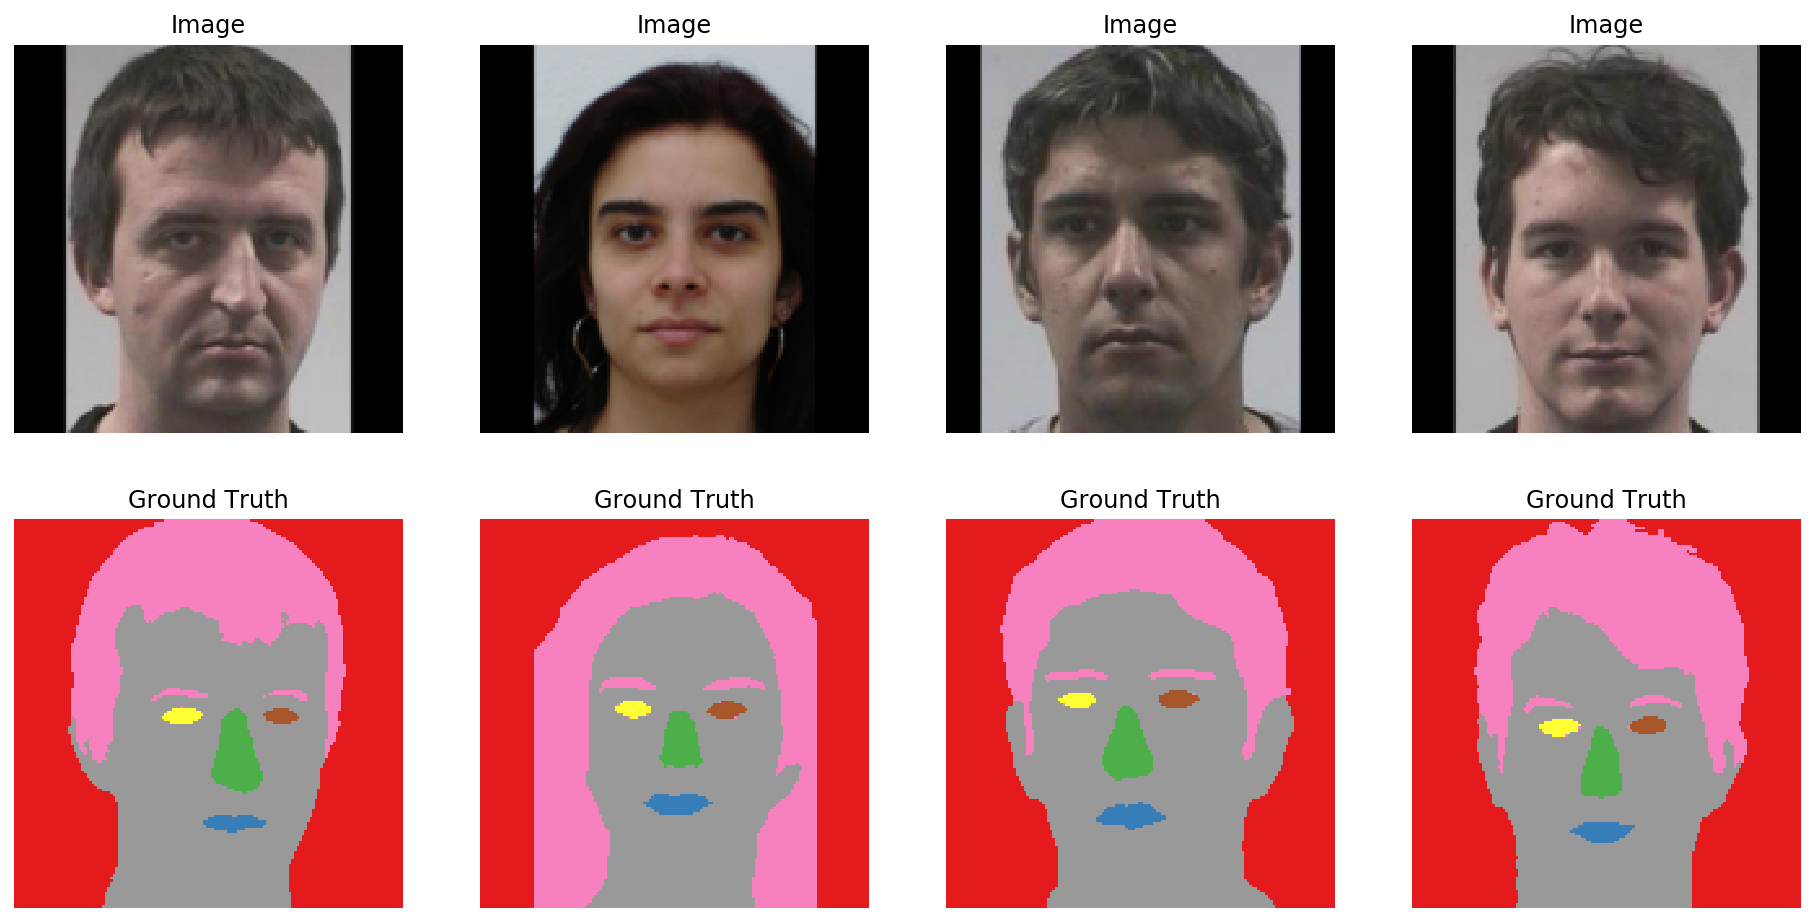

In [42]:
# Inspect some of the images
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16,8))
for i in range(4):
    axi = ax[:,i]
    util.view_data(img=X_train[i], gt=Y_train[i], axis=0, ax=axi)

## Section 3 - Modelling

In [43]:
def score_seg_model(model, X_test, y_test):
    '''
    Returns accurancy score and classification report for a given model.

    Parameters:
        model: model to be evaluated.
        X_test: test data.
        y_test: ground truths.
        
    '''
    
    # Set model.verbose to 0 to prevent clutered outputs
    model.verbose = 0
    
    print('Accuracy Score', model.score(X_test, y_test))
    
    y_test_predict = model.predict(X_test)
    
    lb = [(key, mapping[key]) for key in mapping.keys()]
    labels = [i[1] for i in lb]
    target_names= [i[0] for i in lb]

    print(
        classification_report(y_test,
                              y_test_predict,
                              labels = labels,
                              target_names=target_names))

### Model 1 - RF No HOG

In [44]:
# Reload modules
reload_modules()

# Define feature parameters
feature_params = {'color': 'gray', 
                  'loc': True}

# Create preditor features
feat = ftp.CreateFeatures(feature_params)

# Model
rfc1 = RandomForestClassifier(n_estimators=10, verbose=0, n_jobs=-1)

# Setup pipe
steps = [('features', feat), ('model', rfc1)]
pipe = Pipeline(steps)

In [45]:
# Fit the model
pipe.fit(X_train, Y_train.ravel());

In [46]:
# Score the model
score_seg_model(pipe, X_test, Y_test.ravel())

Accuracy Score 0.9345462962962963
              precision    recall  f1-score   support

       mouth       0.69      0.66      0.67      4709
        skin       0.94      0.92      0.93    194456
        hair       0.90      0.92      0.91    122930
        nose       0.74      0.70      0.72      8572
          nc       0.97      0.98      0.98    205415
    left_eye       0.55      0.61      0.58      1923
   right_eye       0.56      0.58      0.57      1995

    accuracy                           0.93    540000
   macro avg       0.76      0.77      0.76    540000
weighted avg       0.93      0.93      0.93    540000



In [47]:
Y_pred = pipe.predict(X_test).reshape(Y_test.shape)

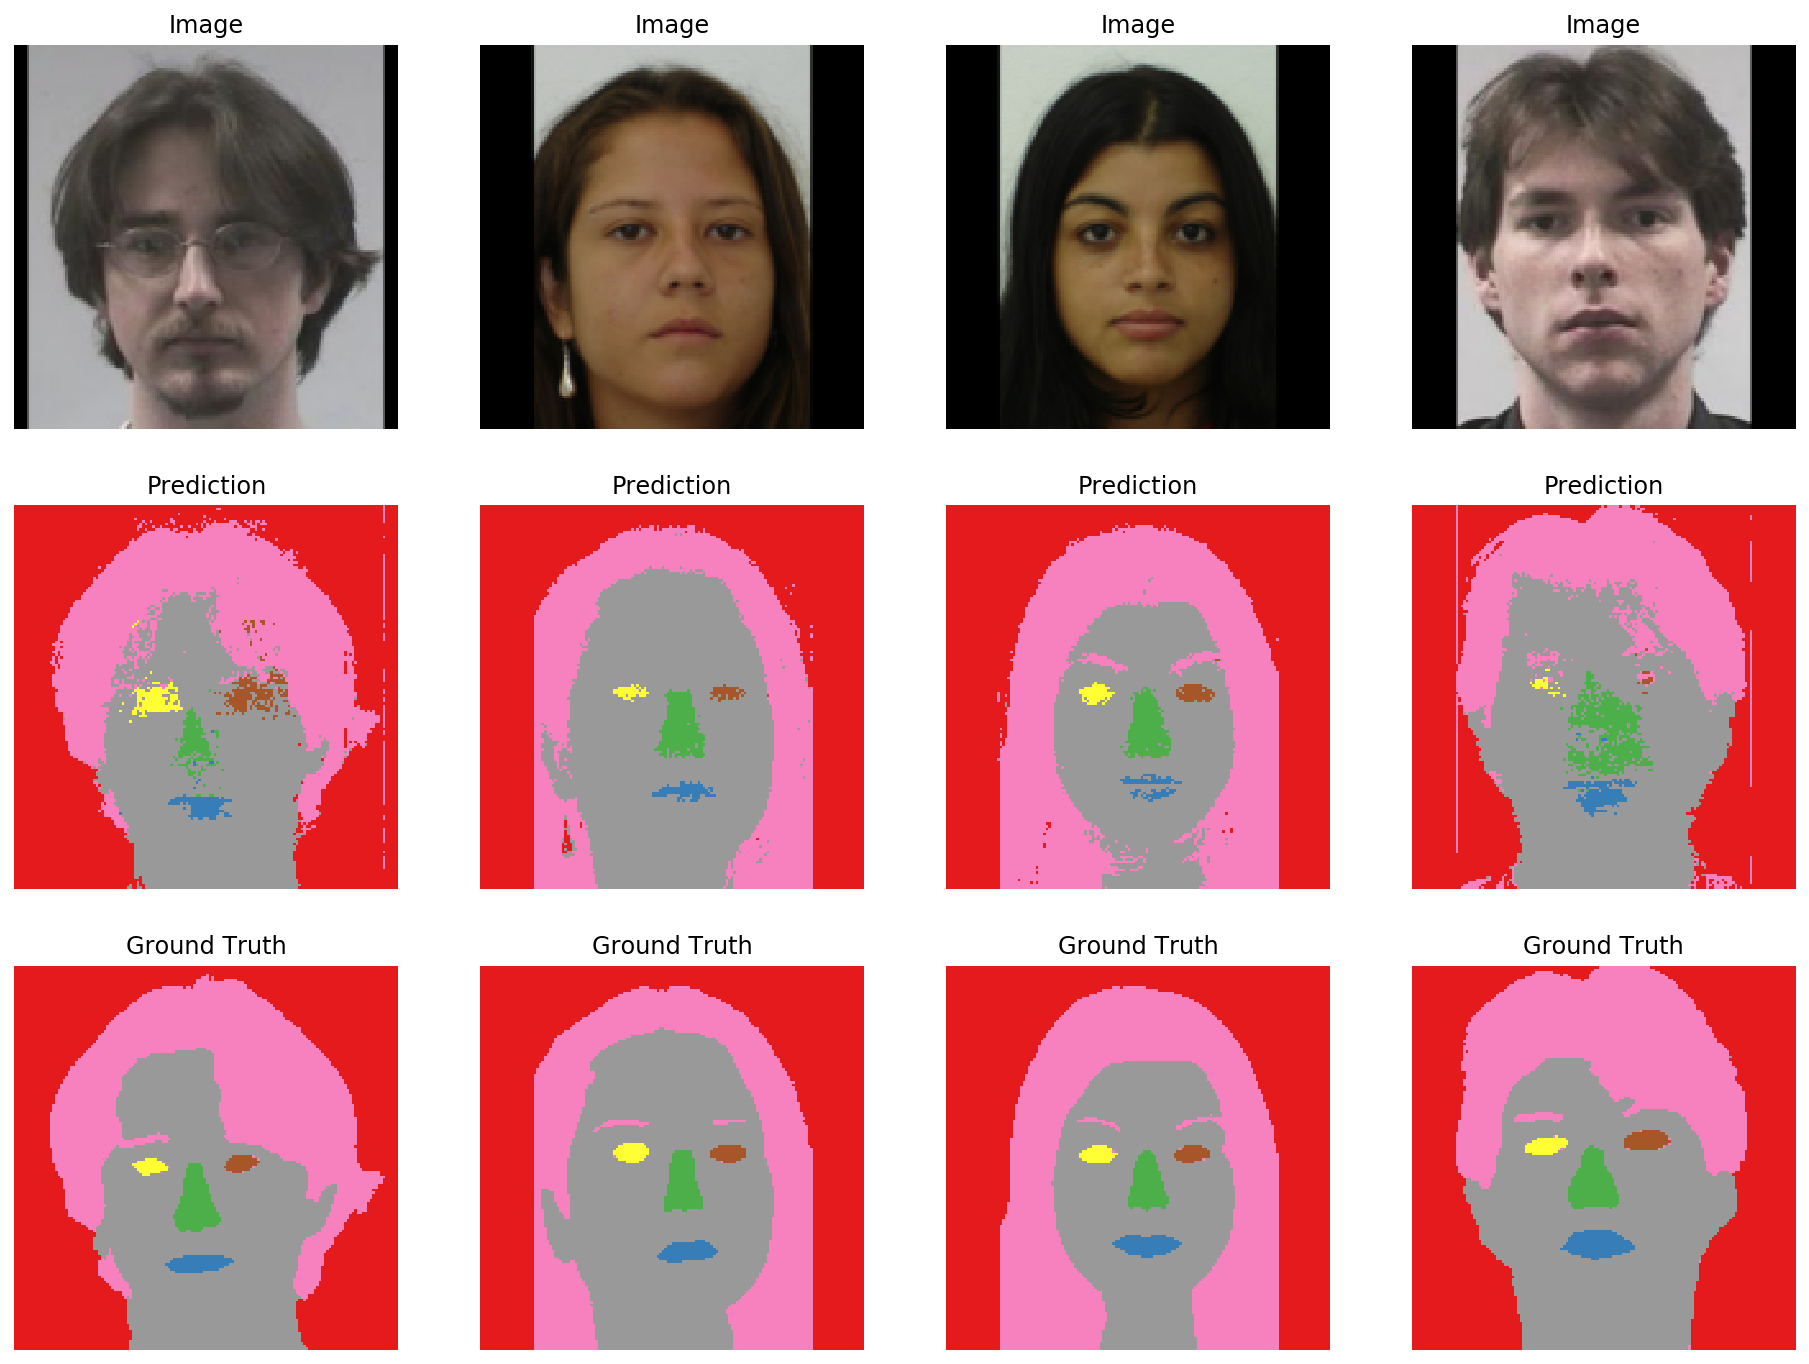

In [48]:
# Inspect some of the predictions
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(16,12))
for i in range(4):
    axi = ax[:,i]
    util.view_data(img=X_test[i], gt=Y_test[i],pred=Y_pred[i], axis=0, ax=axi)

### Model 2 - RF with HOG

In [55]:
class CustomGridSearchCV():
    '''
    Grid search class to mimic scikit-learn, only fit method implemented
    '''
    def __init__(self,
                 estimator,
                 param_grid,
                 cv=3,
                 refit=True,
                 random_state=None):
        
        self.base_estimator = estimator
        self._estimator = copy.deepcopy(estimator)
        self.param_grid = param_grid
        self.pg = ParameterGrid(param_grid)
        self.refit = refit
        self.kf = kf = KFold(n_splits=cv, random_state=random_state)
        self.best_estimator_ = None
        self.scores_ = np.zeros((cv, 1))

    def fit(self, X, Y):
        best_score = 0
        for params in iter(tqdm(self.pg, desc='Grid search')):
            estimator = self._estimator
            estimator.set_params(**params)
            cv_scores = np.array(self._cross_val(estimator, X, Y))
            if cv_scores.mean() > self.scores_.mean():
                self.best_estimator_ = copy.deepcopy(estimator)
                self.scores_ = cv_scores

        if self.refit:
            self.best_estimator_.fit(X, Y.ravel())

    def _cross_val(self, estimator, X, Y):
        split_indices = self.kf.split(X_train, Y_train)

        cv_scores = []
        for ix in split_indices:
            train_ix = ix[0]
            test_ix = ix[1]
            estimator.fit(X_train[train_ix], Y_train[train_ix].ravel())
            score = estimator.score(X_train[test_ix], Y_train[test_ix].ravel())
            cv_scores.append(score)

        return cv_scores

    def score():
        pass

    def predict():
        pass

In [56]:
# Create preditor features
features = ftp.CreateFeatures(color='color', loc=True, hog=(5,5))

# Model
rfc2 = RandomForestClassifier(n_estimators=80, verbose=0, n_jobs=-1, class_weight='balanced', random_state=0)

# Setup pipe
steps = [('features', features), ('model', rfc2)]
pipe2 = Pipeline(steps)
save_path = '../models/optimal_rf.z'

In [57]:
# from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': range(40, 100, 10),
    'features__hog': [(5, 5), (10, 10), (15, 15), False]
}

gs = CustomGridSearchCV(pipe2, param_grid, cv=3, random_state=0)
gs.fit(X_train, Y_train)

# Save the best model
optimal_model = gs.best_estimator_
joblib.dump(optimal_model, save_path, compress=('zlib',7))

['../models/optimal_rf']

In [62]:
optimal_model = joblib.load(save_path)

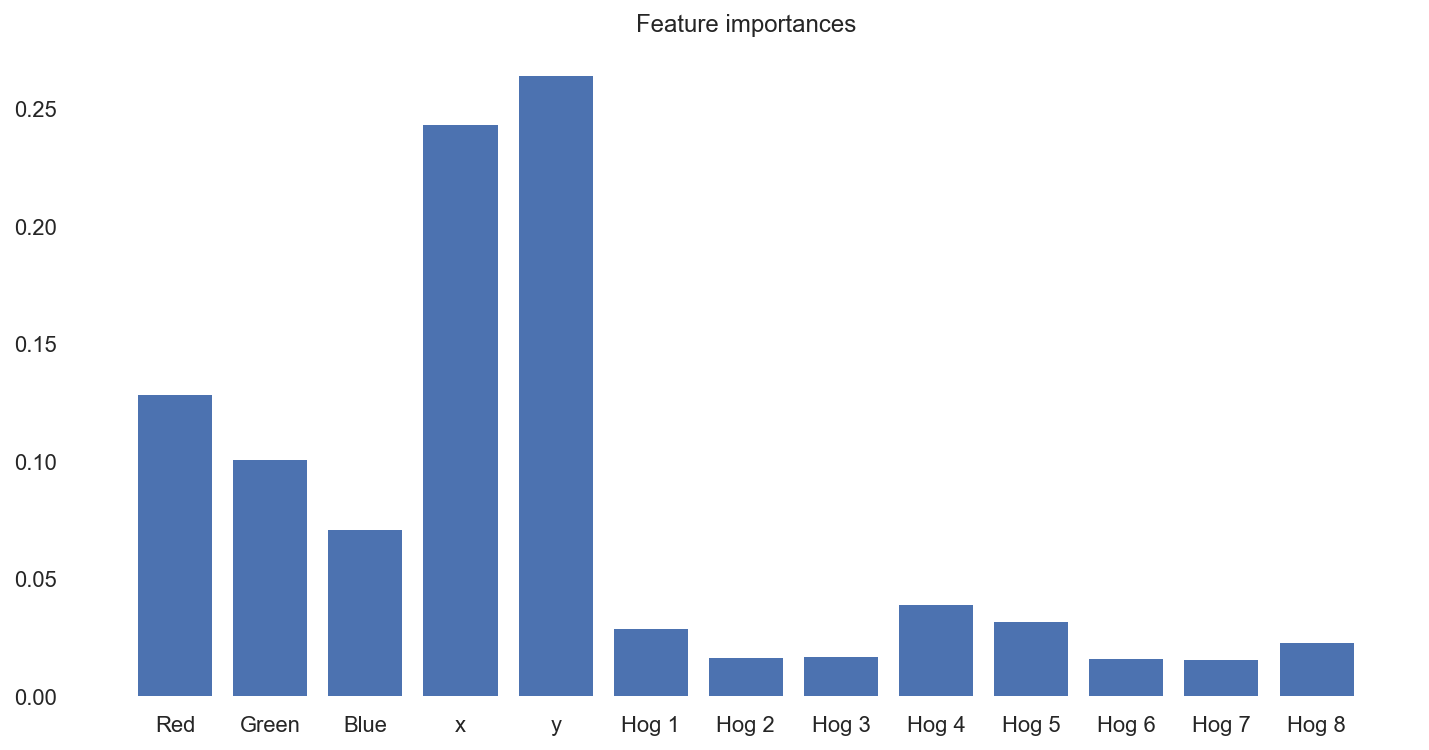

In [66]:
import seaborn as sns
sns.set()

x = ['Red', 'Green', 'Blue', 'x', 'y', 'Hog 1', 'Hog 2', 'Hog 3', 'Hog 4', 'Hog 5', 'Hog 6', 'Hog 7', 'Hog 8']
sns.set()


fig, ax = plt.subplots(figsize=(12,6))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.bar(x, optimal_model.named_steps['model'].feature_importances_);
ax.set_title('Feature importances');
plt.style.use('bmh')

In [67]:
optimal_model

Pipeline(memory=None,
         steps=[('features',
                 CreateFeatures(color='color', hog=(5, 5), loc=True)),
                ('model',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=80, n_jobs=-1,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [68]:
score_seg_model(optimal_model, X_test, Y_test.ravel())

Accuracy Score 0.9451351851851851
              precision    recall  f1-score   support

       mouth       0.80      0.56      0.66      4709
        skin       0.93      0.95      0.94    194456
        hair       0.93      0.93      0.93    122930
        nose       0.85      0.61      0.71      8572
          nc       0.98      0.98      0.98    205415
    left_eye       0.68      0.46      0.55      1923
   right_eye       0.76      0.47      0.58      1995

    accuracy                           0.95    540000
   macro avg       0.85      0.71      0.76    540000
weighted avg       0.94      0.95      0.94    540000



In [69]:
Y_pred = optimal_model.predict(X_test).reshape(Y_test.shape)

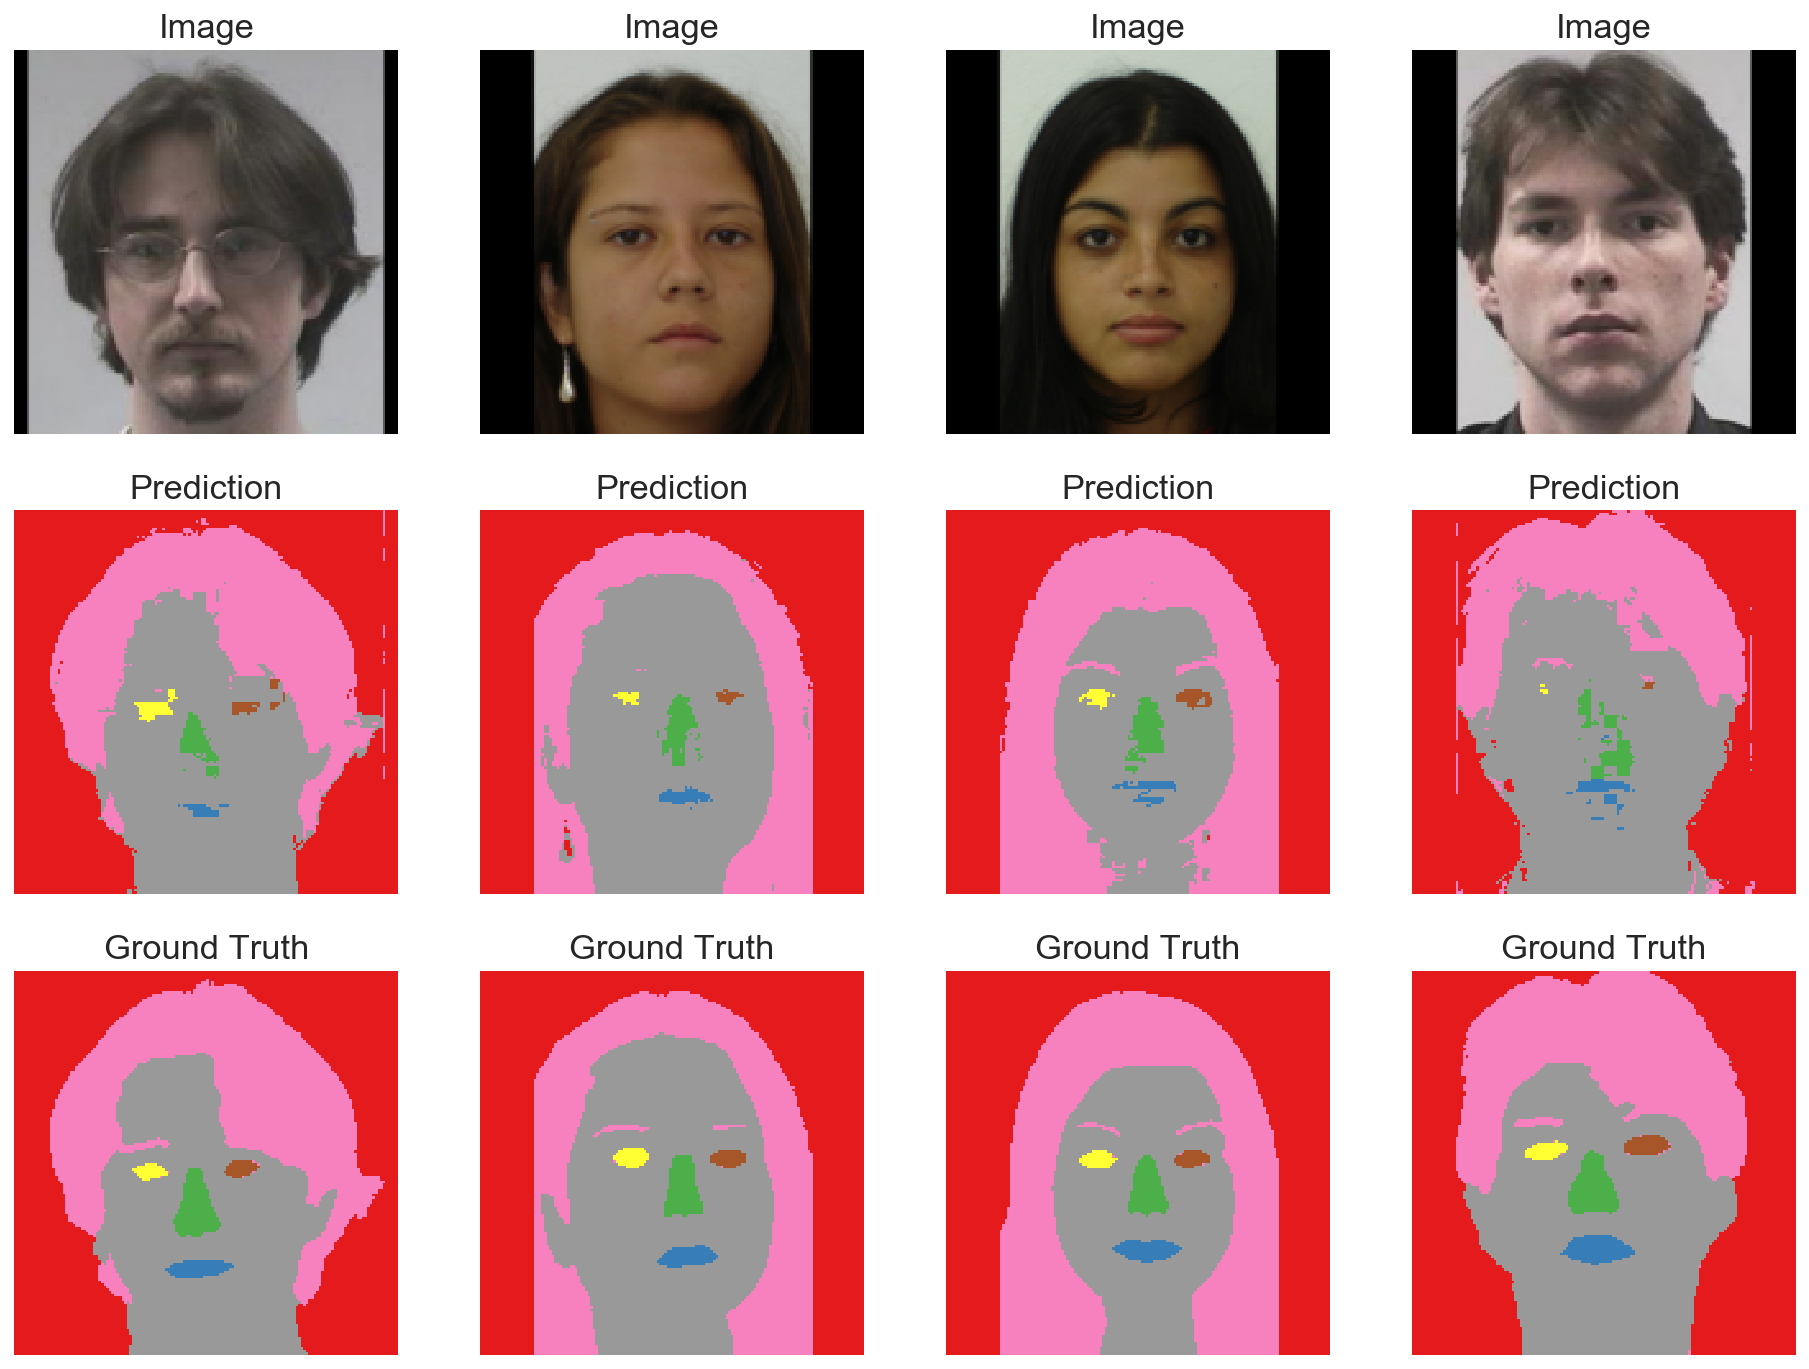

In [70]:
# Inspect some of the images
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(16,12))
for i in range(4):
    axi = ax[:,i]
    util.view_data(img=X_test[i], gt=Y_test[i],pred=Y_pred[i], axis=0, ax=axi)

### Model evaluation

In [83]:
from scikitplot.metrics import plot_roc, plot_precision_recall

In [70]:
# Need to probabilities calculated by the classifier
Y_prob_pred = optimal_model.predict_proba(X_test)

In [79]:
Y_test.ravel()

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [80]:
Y_prob_pred[50,:]

array([0.9   , 0.    , 0.    , 0.    , 0.    , 0.0625, 0.0375])

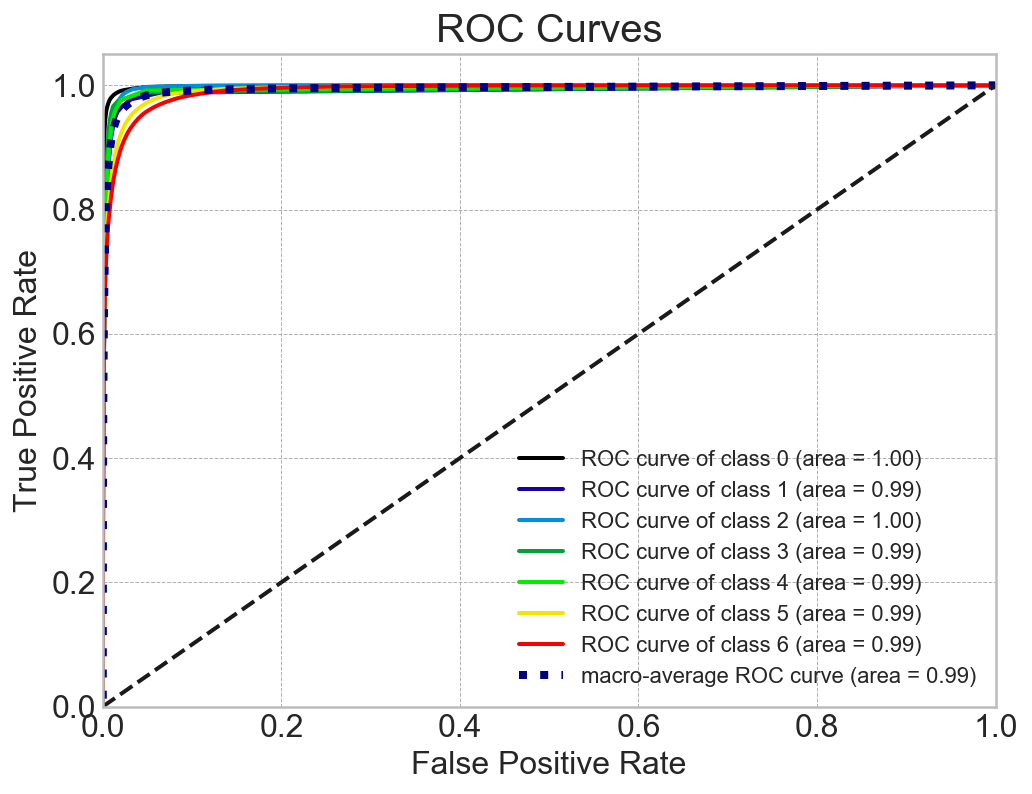

In [123]:

plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)


plot_roc(Y_test.ravel(), Y_prob_pred, ax= ax, title_fontsize=20, text_fontsize=16, plot_micro=False)
plt.legend(framealpha=0);

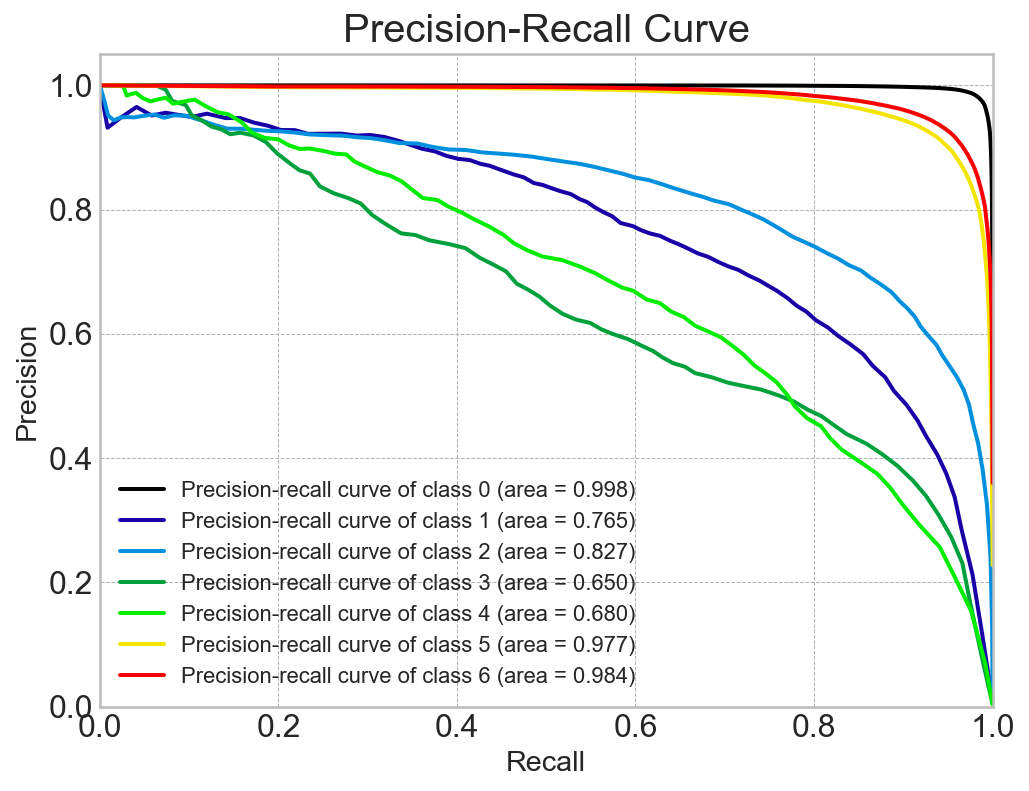

In [124]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plot_precision_recall(Y_test.ravel(), Y_prob_pred, ax=ax, title_fontsize=20, text_fontsize=16, plot_micro=False)
plt.legend(framealpha=0);